In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data loading and cleaning



In [0]:
train_data = pd.read_csv('train.csv', index_col=0).replace('na', np.nan).astype(np.float64)
val_data = pd.read_csv('val.csv', index_col=0).replace('na', np.nan).astype(np.float64)

data=pd.concat([train_data, val_data])

In [23]:
data.head()

,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,colc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
objid,,,,,,,,,,,,,,,,,,,,,
78023,121.079395,-9.343143,25.46583,22.53827,21.52258,NaN,NaN,1.0,107.03430,68.61757,...,-0.184090,-0.054633,NaN,NaN,6.0,5.0,6.0,5.0,2.0,0.0
67239,121.080753,-9.339397,23.64559,24.57786,21.76326,20.94348,21.52855,1.0,134.68570,91.86983,...,0.371713,-0.128548,-0.122364,NaN,6.0,8.0,1.0,1.0,0.0,0.0
48461,121.070386,-9.332728,24.88126,23.49473,22.23877,21.38574,21.51635,1.0,84.76380,190.93810,...,0.004125,0.014147,-0.051568,NaN,6.0,4.0,6.0,4.0,5.0,0.0
55564,121.083052,-9.334026,23.57384,21.42411,20.43948,19.99905,19.82959,1.0,177.05670,123.68290,...,-0.080959,NaN,-0.089301,NaN,3.0,4.0,5.0,2.0,4.0,0.0
96180,121.063351,-9.325032,23.85167,20.25245,19.60670,19.18877,19.08231,1.0,65.37769,283.06600,...,-0.037828,-0.097120,NaN,0.106472,3.0,4.0,7.0,6.0,3.0,0.0


## Let's see class counts in train and val data



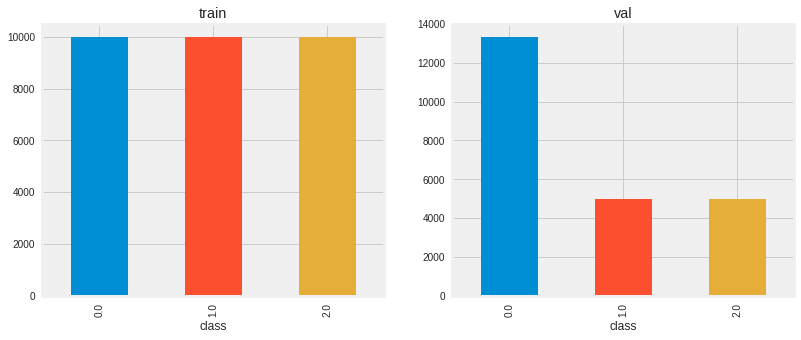

In [24]:
fig = plt.figure(figsize=(12,5))
ax0, ax1 = fig.subplots(1, 2)

ax0.set_title('train')
ax1.set_title('val')
train_data.groupby('class')['class'].count().plot('bar', ax=ax0);
val_data.groupby('class')['class'].count().plot('bar', ax=ax1);

## Сhecking for total null values 

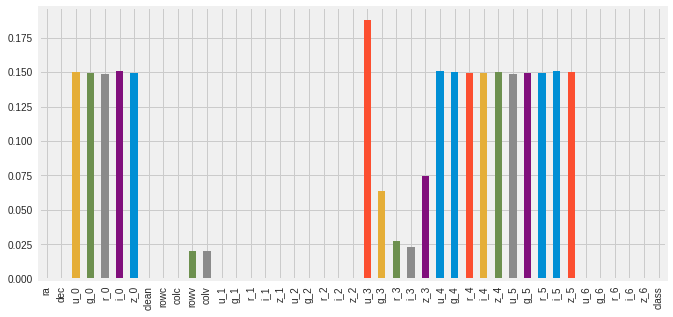

In [25]:
plt.figure(figsize=(10,5))
data.isnull().mean().plot('bar');

*   **pretty big part of data has nan values**
*   **need to think about strategy for filling it **


## Is there any dependencies between nan values and answers


### Same amount of samples with nan in all groups 

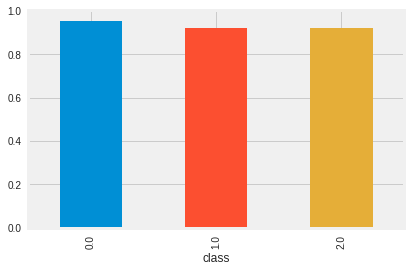

In [26]:
data.groupby('class').apply(lambda x: x.isnull().any(axis=1).mean()).plot('bar');

## In 0-class amount of nans per sample is higher than in others

---





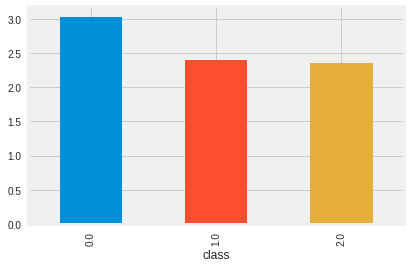

In [27]:
data.groupby('class').apply(lambda x: x.isnull().sum(axis=1).mean()).plot('bar');

## Here we can see the real distribution of nan amount between classes

In [28]:
pd.crosstab(data['class'], data.isnull().sum(axis=1)).T.style.background_gradient(cmap='summer_r')  

class,0.0,1.0,2.0
col_0,,,
0,1057,1182,1166
1,3401,3065,3290
2,5277,4220,4217
3,5382,3382,3361
4,3921,1948,1874
5,2272,849,731
6,1111,264,267
7,527,67,66
8,245,9,17


## Now let's take a look at coordinates of samples

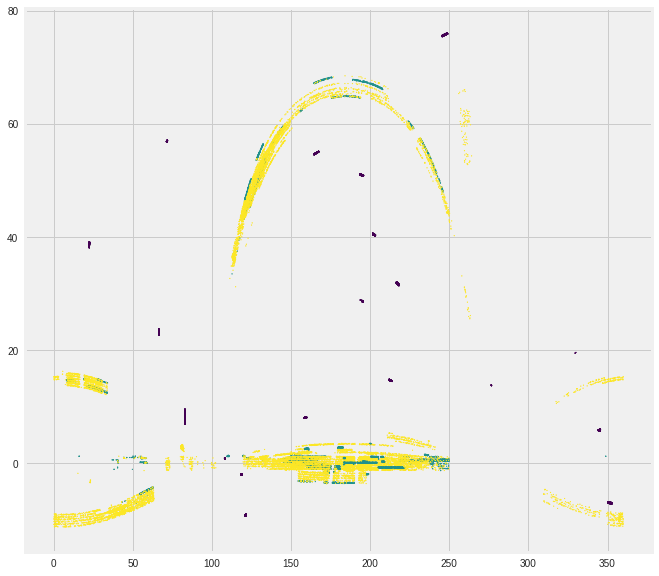

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(x=data['ra'], y=data['dec'], c=data['class'], cmap='viridis', s=0.5);

* **I don't think that we are able to use coordinates as features for our model beacause they are absolutely different for train and test datasets**

* **But first thing that I thaught about was that DBSCAN can easily recognize small groups as classes **

## Let's see what we can do using unsupervised ml algorithms
### Here we will distinguish only clusters and non-clusters

(array([False,  True]), array([23264, 30069]))

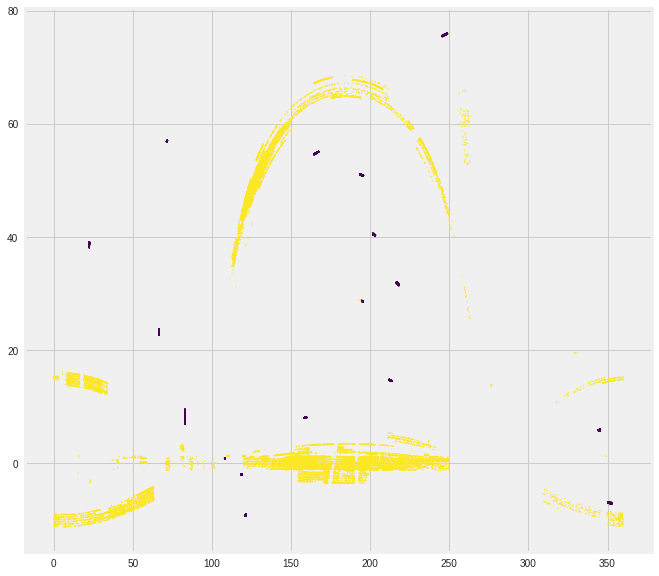

In [30]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.4, min_samples=150, n_jobs=-1).fit(data[['ra', 'dec']])

plt.figure(figsize=(10,10))
plt.scatter(x=data['ra'], y=data['dec'], c=clustering.labels_==-1, cmap='viridis', s=0.5);
np.unique(clustering.labels_==-1, return_counts=True)

* **It can be pretty good feature to classificate 0-class**

## Let's look at coordinates of objects in frame 

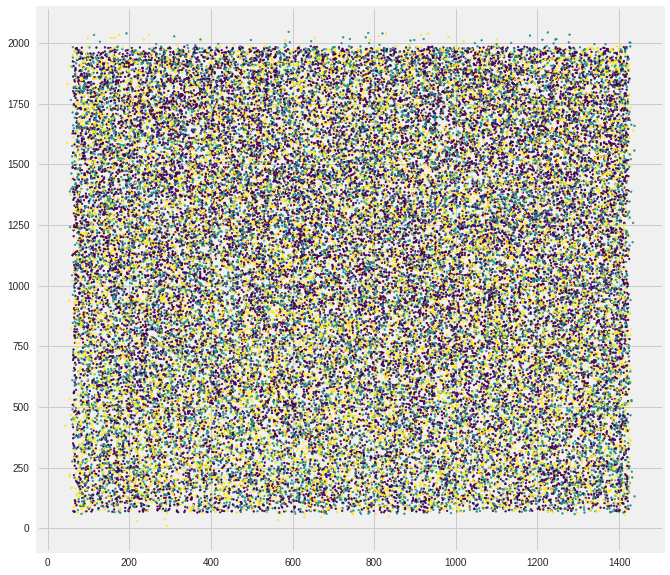

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(x=data['rowc'], y=data['colc'], c=data['class'], cmap='viridis', s=3);

* **as expected plot looks like white noise**


## Now the same with velocity

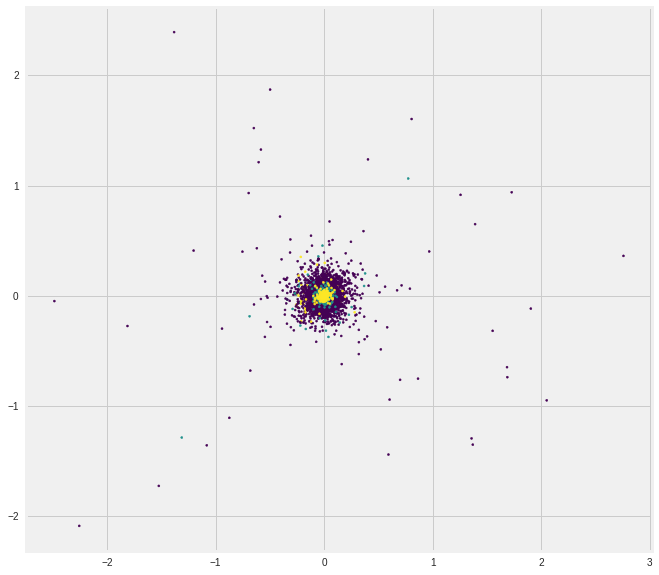

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(x=data['rowv'], y=data['colv'], c=data['class'], cmap='viridis', s=4);

* **pretty clear that 0-class objects are faster than others in any direction**

## We can add features like absolute velocity and total velocity

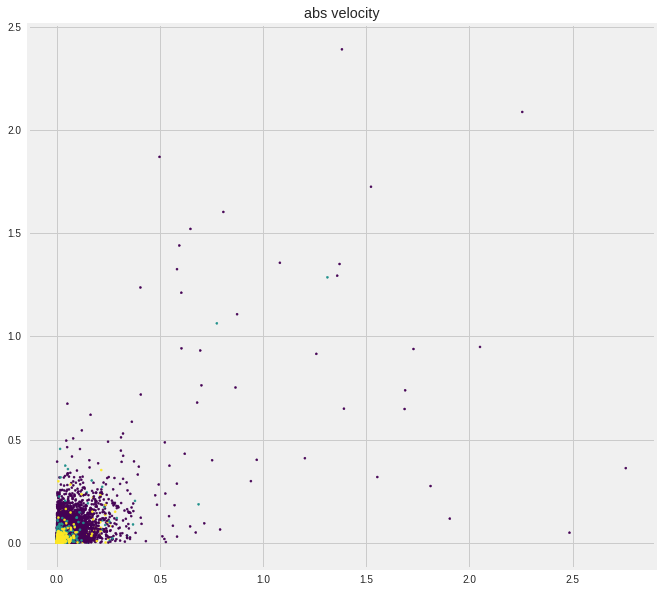

In [33]:
plt.figure(figsize=(10,10))
plt.scatter(x=data['rowv'].abs(), y=data['colv'].abs(), c=data['class'], cmap='viridis', s=4);
plt.title('abs velocity')
plt.show()

## Lets add feature like  $rowv^2 + rowc^2$

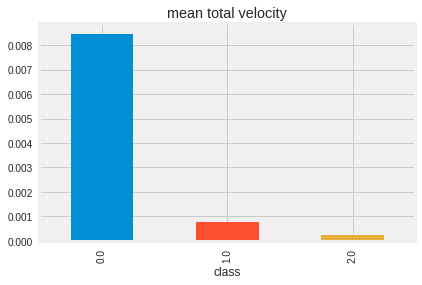

In [34]:
data['radius_squared'] = np.square(data['rowv']) + np.square(data['colv'])

data.groupby('class')['radius_squared'].mean().plot('bar')
plt.title('mean total velocity')
plt.show()

## Let's take a look at dependencies between clean shot and classes

In [35]:
pd.crosstab(data['class'], data['clean'], normalize='columns').T.style.background_gradient(cmap='summer_r')  

class,0.0,1.0,2.0
clean,,,
0.0,0.8022,0.145385,0.0524151
1.0,0.34857,0.31438,0.337049


## Categorical filters analysis

In [0]:
filters = ['u', 'g', 'r', 'i', 'z']

In [37]:
for filter in filters:
  display(
  pd.crosstab(data['class'], data[filter+'_6'], normalize='columns').T.style.background_gradient(cmap='viridis'))  

class,0.0,1.0,2.0
u_6,,,
0.0,0.047619,0.52381,0.428571
3.0,0.530474,0.322027,0.147499
6.0,0.316452,0.227792,0.455756


class,0.0,1.0,2.0
g_6,,,
0.0,0,0.5,0.5
1.0,0,0.666667,0.333333
2.0,0,0.5,0.5
3.0,0.616633,0.330847,0.0525202
4.0,0.607975,0.342183,0.0498421
5.0,0.602678,0.342981,0.0543414
6.0,0.206562,0.202625,0.590814
7.0,0.216174,0.204308,0.579518
8.0,0.217881,0.210635,0.571484


class,0.0,1.0,2.0
r_6,,,
0.0,0,1,0
1.0,0.626658,0.320939,0.0524027
2.0,0.434834,0.284035,0.28113
3.0,0.43513,0.283433,0.281437
4.0,0.44604,0.280797,0.273163
5.0,0.442468,0.267684,0.289847
6.0,0.433057,0.288791,0.278153
7.0,0.437166,0.283179,0.279655
8.0,0.139249,0.218345,0.642406


class,0.0,1.0,2.0
i_6,,,
0.0,0,1,0
1.0,0.611477,0.31484,0.0736824
2.0,0.601022,0.322001,0.0769773
3.0,0.442121,0.275605,0.282274
4.0,0.437465,0.276353,0.286182
5.0,0.4363,0.284617,0.279083
6.0,0.43469,0.278731,0.286579
7.0,0.132634,0.22702,0.640345
8.0,0.138898,0.229606,0.631496


class,0.0,1.0,2.0
z_6,,,
0.0,0.26416,0.227385,0.508455
1.0,0.25153,0.230693,0.517777
2.0,0.269123,0.220387,0.510491
3.0,0.527281,0.313747,0.158972
4.0,0.529226,0.3092,0.161575
5.0,0.529922,0.305933,0.164145
6.0,0,0.571429,0.428571
7.0,0,0.666667,0.333333
8.0,0,0.6,0.4


* **here we can see than these features are very important**
* **but some categories of filters that have the same distributuion between classes don't bring us more info**

## Let's try to encode data to less classes but keep all informaition 

In [38]:
g_6 = dict(zip(range(9), [0,1,0,2,2,2,3,3,3]))
r_6 = dict(zip(range(9), [0,1,2,2,2,2,2,2,3]))
i_6 = dict(zip(range(9), [0,1,1,2,2,2,2,3,3]))
z_6 = dict(zip(range(9), [0,0,0,1,1,1,2,3,2]))
  

data['g_6'] = data['g_6'].map(g_6)
data['r_6'] = data['r_6'].map(r_6)
data['i_6'] = data['i_6'].map(i_6)
data['z_6'] = data['z_6'].map(z_6)

for filter in filters:
  display(
  pd.crosstab(data['class'], data[filter+'_6'], normalize='columns').T.style.background_gradient(cmap='viridis'))

class,0.0,1.0,2.0
u_6,,,
0.0,0.047619,0.52381,0.428571
3.0,0.530474,0.322027,0.147499
6.0,0.316452,0.227792,0.455756


class,0.0,1.0,2.0
g_6,,,
0,0,0.5,0.5
1,0,0.666667,0.333333
2,0.609037,0.338729,0.0522344
3,0.213575,0.20587,0.580556


class,0.0,1.0,2.0
r_6,,,
0,0,1,0
1,0.626658,0.320939,0.0524027
2,0.438126,0.281353,0.280521
3,0.139249,0.218345,0.642406


class,0.0,1.0,2.0
i_6,,,
0,0,1,0
1,0.606291,0.318392,0.0753167
2,0.437637,0.278827,0.283535
3,0.135733,0.2283,0.635967


class,0.0,1.0,2.0
z_6,,,
0,0.261613,0.226156,0.512231
1,0.528812,0.309617,0.16157
2,0,0.583333,0.416667
3,0,0.666667,0.333333


* **now every category of filters gives us good understanding of probability of sample class**


## Real valued filters analysis

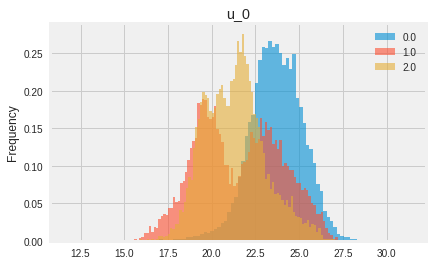

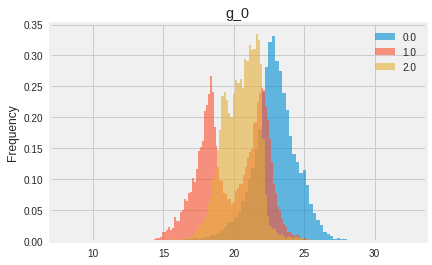

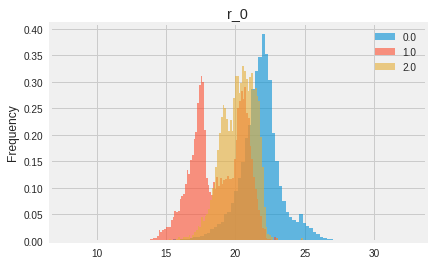

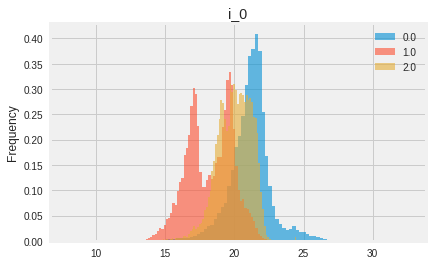

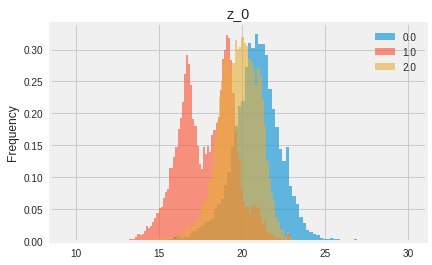

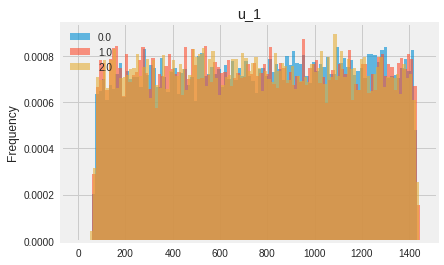

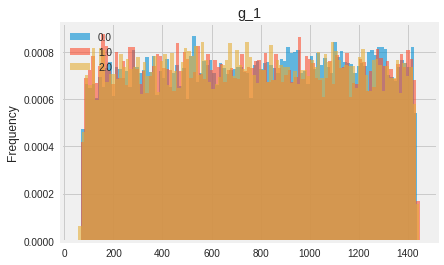

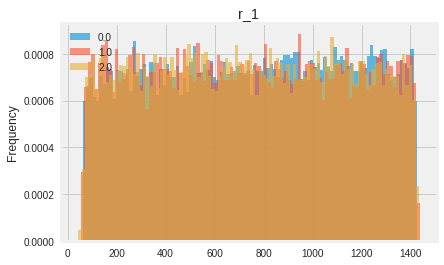

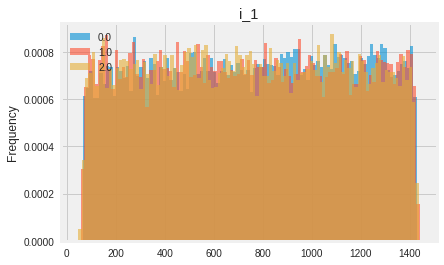

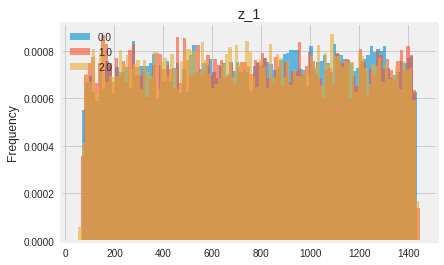

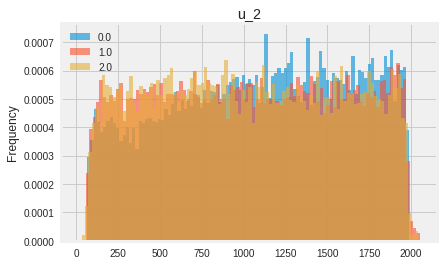

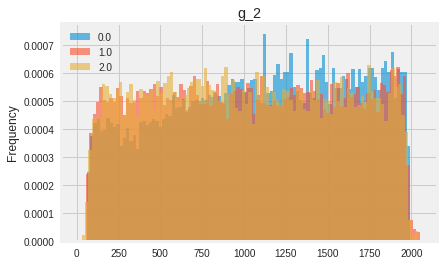

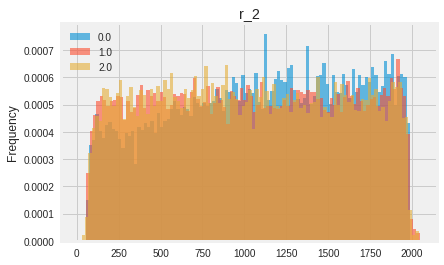

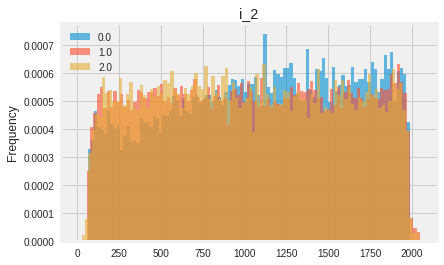

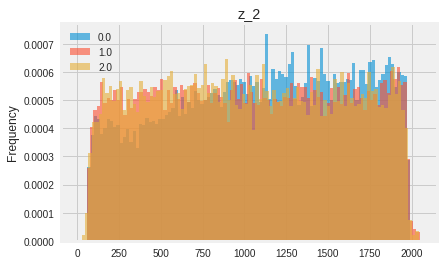

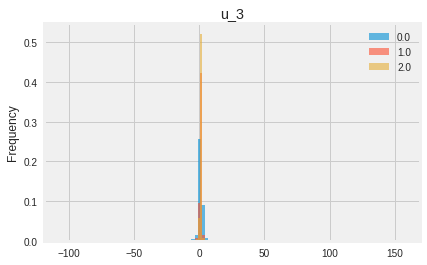

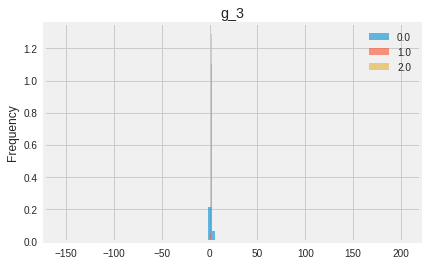

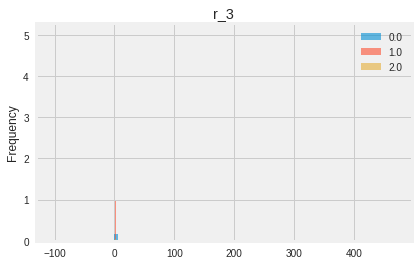

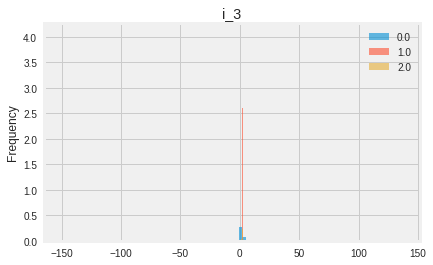

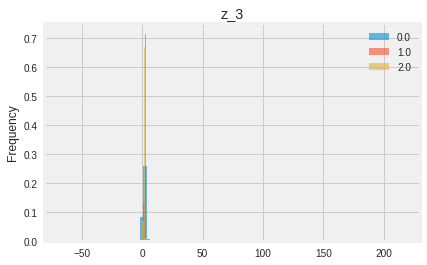

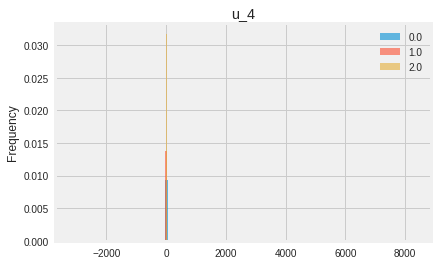

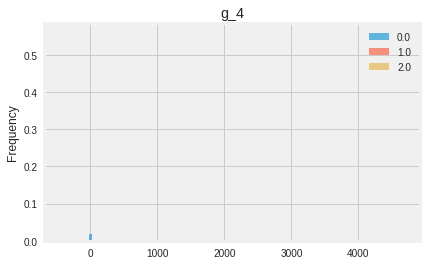

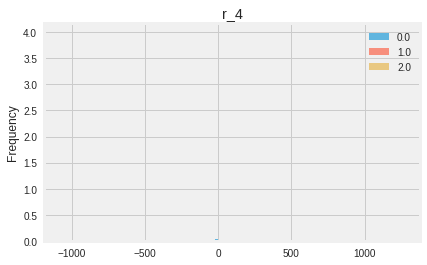

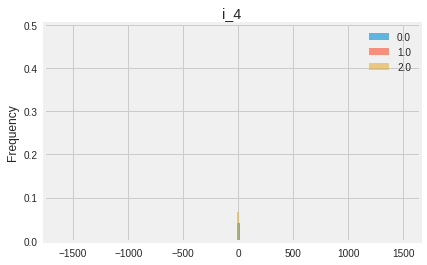

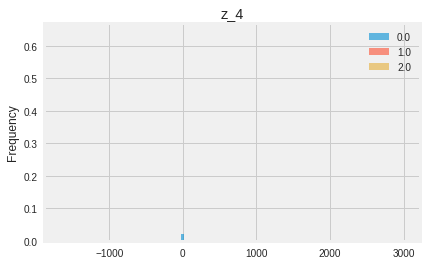

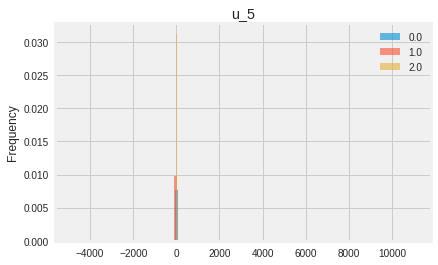

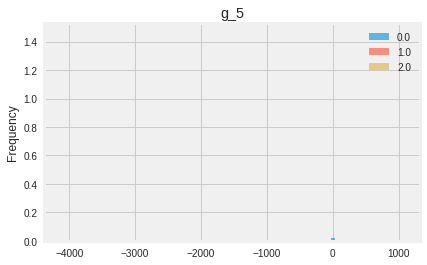

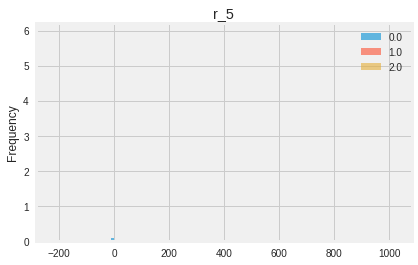

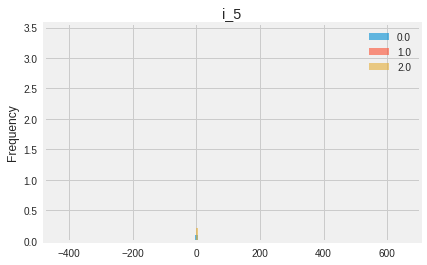

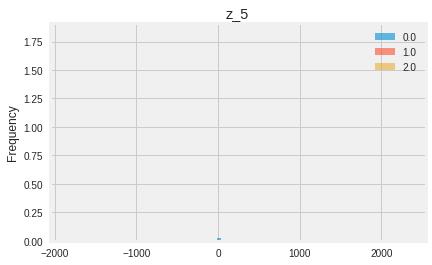

In [39]:
for i in range(6):
  for filter in filters:
    data.groupby('class')[f'{filter}_{i}'].plot('hist', legend=True, bins=100, alpha=0.6, normed=True)
    plt.title(f'{filter}_{i}')
    plt.show()

## Let' build filters corr map

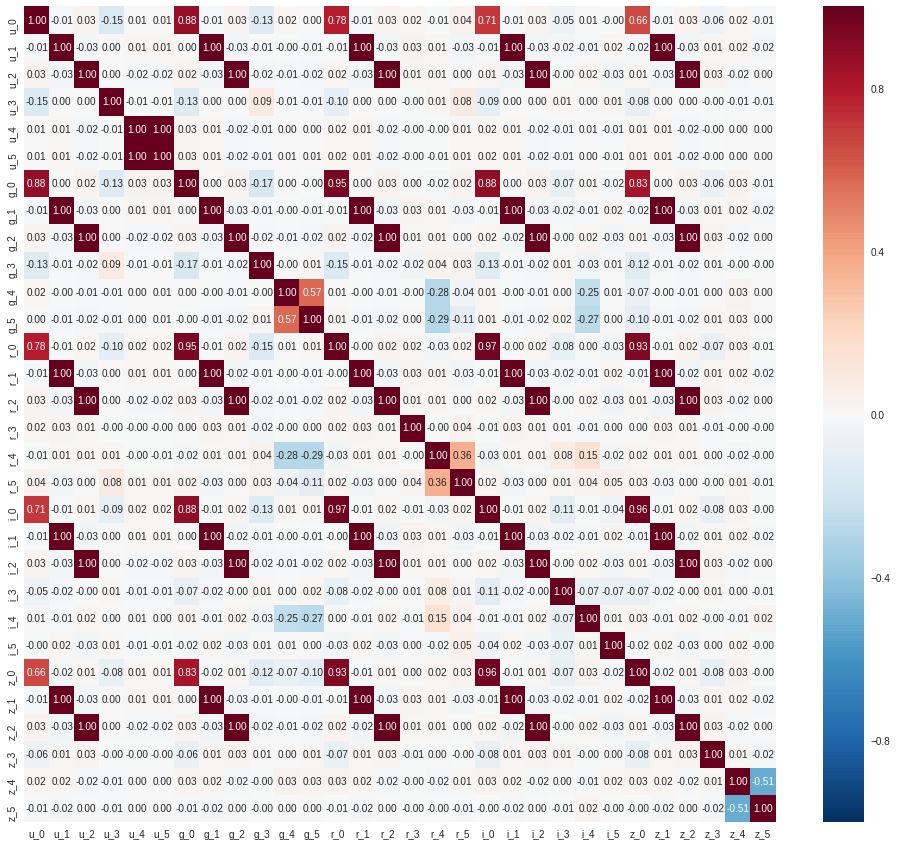

In [40]:
real_filters = [f'{filter}_{i}' for filter in filters for i in range(6)]
corr = data[real_filters].dropna().corr()

# plot the heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f',)
plt.show()

* **not very good, we'll probaply have to drop most of these filters**